# Fitting the NBEs from Rison et al. 2016 Nat Comm paper

In [1]:
using StaticArrays
using LinearAlgebra
using DelimitedFiles

# This is my package to compute the fields created by TLs
using DipoleRadiators

In [2]:
#initplot(:jupyter)
using Plots
theme(:vibrant)
gr(frame=:box, linewidth=2.0)

Plots.GRBackend()

## NBE1

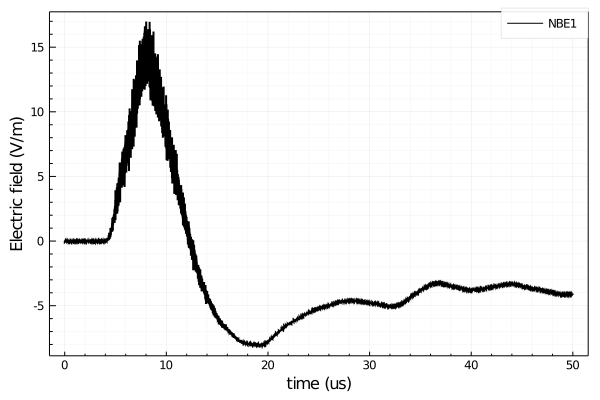

In [3]:
# Load observational data
tdata, ydata = eachcol(readdlm("data/NBE1.dat"));

# The code expects time in s
tdata .*= 1e-6
plot(tdata / 1e-6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="Electric field (V/m)")

In [4]:
"""
Set up a MTLE the transmission line as a union of dipoles.
"""
function channel(;ϕ=0.0, θ=0.0, H2=6e3, Z0=455, λ=900.0, Ipk=51.5e3,
                 τ1=1e-6, τ2=5e-6, v=3.5e7,
                 v1=v, λ1=λ,
                 γ=1.0, Δτ=0.0,
                 bounce=false)
    H1 = H2 - Z0
    
    # Unit vector in the channel direction
    sinϕ, cosϕ = sincos(ϕ)
    sinθ, cosθ = sincos(θ)
    
    u = @SVector [cosϕ * sinθ, sinϕ * sinθ, cosθ]

    # Init and end point of the TL.  I think this is the convention used in
    # the draft.
    r2 = @SVector [0, 0, u[3] * H1]
    r1 = @SVector [u[1] * Z0, u[2] * Z0, u[3] * H2]
    
    # Current pulse
    α, β = 1 / τ1, 1 / τ2

    # Note that here the positive sign of I is from r0 to r1 so since the altitude
    # of r0 is higher than that of r1 and the pulse propagates down we need a
    # positive current.
    I0 = Ipk * (1 + α / β) * (α / β)^(-α / (α + β))

    pulse = CurrentPulse(t -> I0 * (exp(α * t) / (1 + exp((α + β) * t))),
                         -max(τ1, τ2) * 5,
                         max(τ1, τ2) * 20,
                         min(τ1, τ2) / 10)
    
    # This sets an MTLE from r1 to r2 with 1000 dipoles.  mirror means whether
    # to include the ground reflection at z=0.
    tl0 = mtle(pulse, r1, r2, v, λ, 1000, mirror=true)
    bounce || return tl0

    # If bounce is true we set a second transmission line joined to the first
    # where the pulse goes upwards now.
    r3 = r1
    
    tl1 = mtle(pulse, r2, r3, v1, λ1, 1000,
               mirror=true,

               # The minus sign is needed because the convention is that
               # positive current goes from r2 to r3 but we want the current
               # to be in the same direction as in the first ML.
               # exp(-Z0 / λ) is the attenuation in the first ML
               # γ is an optional additional attenuation
               w0=-γ * exp(-Z0 / λ),

               # Z0 / v is the phase introduced by the first ML
               # Δτ is an optional additional phase.
               t0=Z0 / v + Δτ)

    tl = (tl0, tl1)
    
    tl
end

channel

In [5]:
t = range(2e-5, stop=7e-5, length=1000);
robs = @SVector [5.5e3, 0, 0];

First we check against the Uman equation using the standard MTLE

  0.210761 seconds (490.75 k allocations: 24.914 MiB, 5.37% gc time)
  1.288389 seconds (2.61 M allocations: 131.895 MiB, 2.79% gc time)


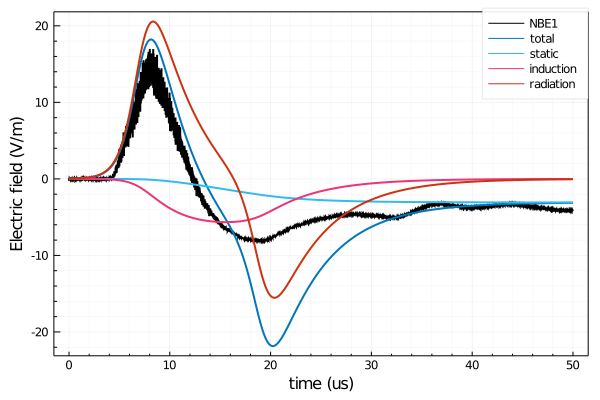

In [6]:
@time tl = channel(Ipk=51.5e3, λ=900, τ1=1e-6, τ2=5e-6)
@time ef = fields(tl, robs, t);

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="Electric field (V/m)");
plot!(t * 1e6 .- 20, total(ef, 3), label="total", lw=2.0);
plot!(t * 1e6 .- 20, static(ef, 3), label="static");
plot!(t * 1e6 .- 20, induction(ef, 3), label="induction");
plot!(t * 1e6 .- 20, radiation(ef, 3), label="radiation")

Now if we use a smaller lambda the fit is a bit better but we cannot fit the electrostatic (long time) part and the "reflection" is still there.

  0.000201 seconds (2.02 k allocations: 218.469 KiB)
  0.079713 seconds (176 allocations: 238.859 KiB)


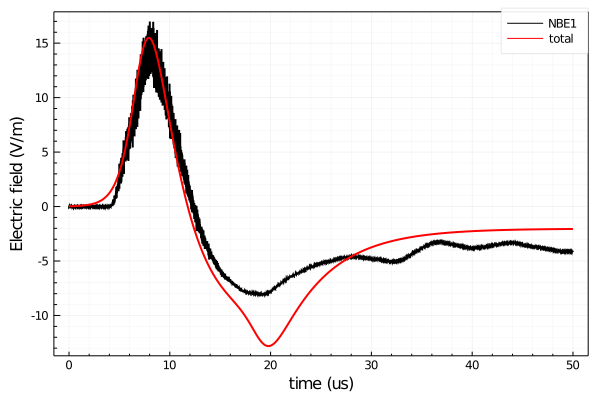

In [7]:
@time tl = channel(Ipk=51.5e3, λ=300, τ1=1e-6, τ2=5e-6)
@time ef = fields(tl, robs, t);

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="Electric field (V/m)");
plot!(t * 1e6 .- 20, total(ef, 3), label="total", lw=2.0, color=:red)

Just by adding the "bouncing" part the "reflection" almost dissapears and the electrostatic component fits better.

  0.000185 seconds (4.03 k allocations: 406.531 KiB)
  0.182972 seconds (29.96 k allocations: 1.884 MiB)


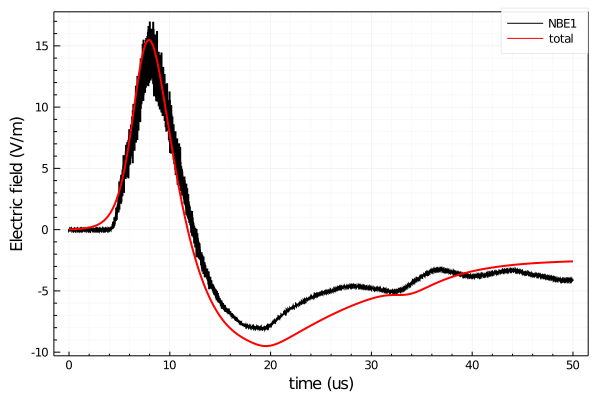

In [8]:
@time tl = channel(Ipk=51.5e3, λ=300, τ1=1e-6, τ2=5e-6, bounce=true)
@time ef = fields(tl, robs, t);

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="Electric field (V/m)");
plot!(t * 1e6 .- 20, total(ef, 3), label="total", lw=2.0, color=:red)

## NBE3

NBE3 seems harder to fit with the model proposed by Rison but as we'll see just changing the current intensity profile leads to a reasonably good fit.  Probably there are a lot of current pulses going on almost simultaneously that hard to account for.

## Vertical channel

In [9]:
t = range(1.7e-5, stop=7e-5, length=1000);
robs = @SVector [3.3e3, 0, 0];

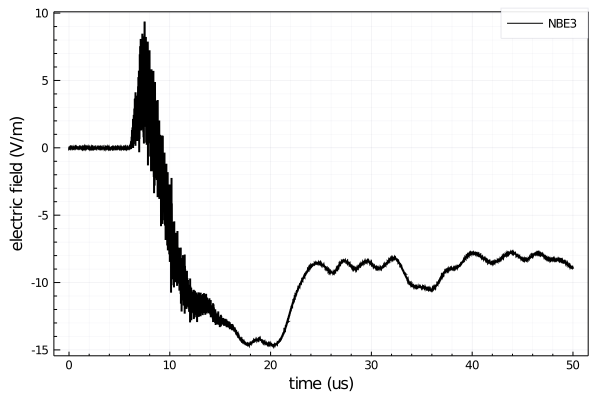

In [10]:
# Load observational data
tdata, ydata = eachcol(readdlm("data/NBE3.dat"))
tdata .*= 1e-6
plot(tdata / 1e-6, ydata, label="NBE3", xlabel="time (us)", ylabel="electric field (V/m)", color=:black)

Clearly the standard MTLE produces a sharp peak that is absent in the observations.  This is what we see with the parameters in the paper:

  0.000153 seconds (2.02 k allocations: 234.031 KiB)
  0.075818 seconds (175 allocations: 238.844 KiB)


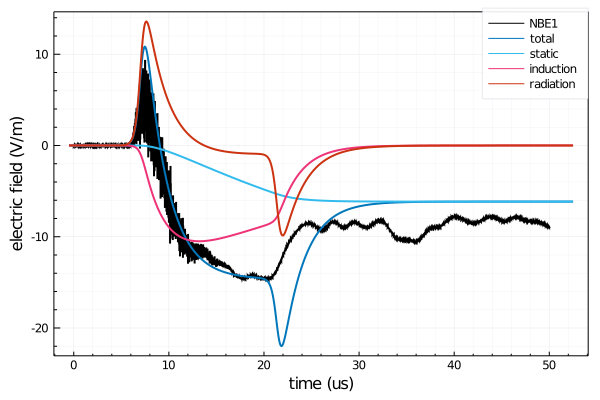

In [11]:
# These are the paper's parameters for the vertical channel
@time tl = channel(H2=6.6e3, Z0=560, Ipk=65.6e3, λ=900, τ1=0.3e-6, τ2=2.3e-6)
@time ef = fields(tl, robs, t);
shift = 17.5

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="electric field (V/m)");
plot!(t * 1e6 .- shift, total(ef, 3), label="total", lw=2.0)
plot!(t * 1e6 .- shift, static(ef, 3), label="static");
plot!(t * 1e6 .- shift, induction(ef, 3), label="induction");
plot!(t * 1e6 .- shift, radiation(ef, 3), label="radiation")

We see that the problem is that the current (proportional to the induction field) is cut off too quickly, which produces the strong radiation peak.  Let's see how the "bounce" improves things.  In this case the INTF data shows that the upward pulse is considerably faster than the downward pulse.  This is reflected in our choice of v1.

  0.000231 seconds (4.03 k allocations: 422.094 KiB)
  0.147637 seconds (203 allocations: 398.031 KiB)


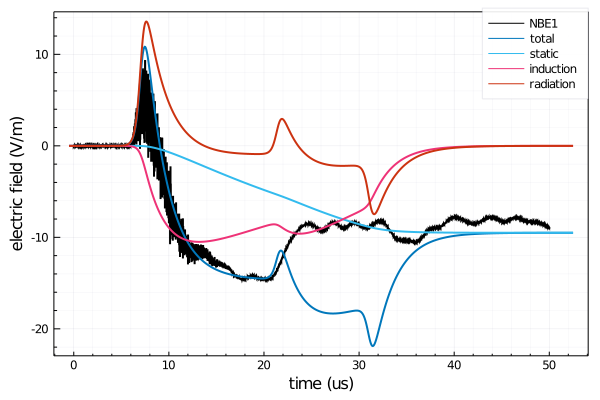

In [12]:
# These are the paper's parameters for the vertical channel
@time tl = channel(H2=6.6e3, Z0=560, Ipk=65.6e3, λ=900, τ1=0.3e-6, τ2=2.3e-6, v1=7e7, bounce=true)
@time ef = fields(tl, robs, t);
shift = 17.5

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="electric field (V/m)");
plot!(t * 1e6 .- shift, total(ef, 3), label="total", lw=2.0)
plot!(t * 1e6 .- shift, static(ef, 3), label="static");
plot!(t * 1e6 .- shift, induction(ef, 3), label="induction");
plot!(t * 1e6 .- shift, radiation(ef, 3), label="radiation")

This creates a bump that is also clearly not in the observational data.

## Slanted channel

First we use the geometry in the paper's figure to check that we get the same result.  Except the radiation peak, which remains there.

In [13]:
t = range(7e-6, stop=7e-5, length=1000);

  0.000138 seconds (2.02 k allocations: 228.219 KiB)
  0.079410 seconds (176 allocations: 239.172 KiB)


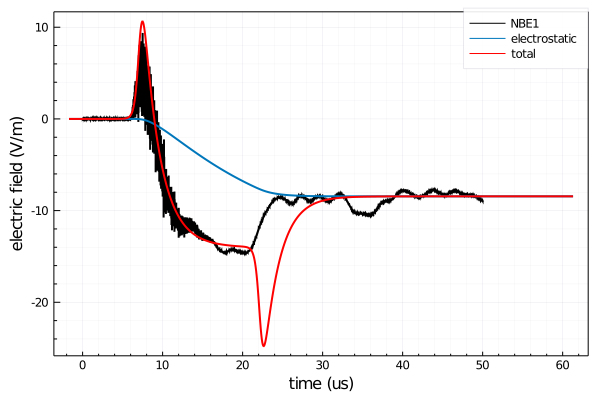

In [14]:
# These are the default parameters - do not change
@time tl = channel(θ=deg2rad(60), ϕ=deg2rad(260), H2=6.6e3, Z0=560, Ipk=69.4e3, λ=900, τ1=0.3e-6, τ2=2e-6)
@time ef = fields(tl, robs, t);

plot(tdata * 1e6, ydata, label="NBE1", color=:black, xlabel="time (us)", ylabel="electric field (V/m)");
plot!(t * 1e6 .- 8.7, static(ef, 3), label="electrostatic", lw=2.0)
plot!(t * 1e6 .- 8.7, total(ef, 3), label="total", lw=2.0, color=:red)

The problem with this geometry is that we don't know if the observation elevation and azimuth are consistent with Rison's paper

In [15]:
"""
  Compute the observation angles for an observer located at robs of a segment
with the geometry defined in the paper.
"""
function obsangles(robs; ϕ=0.0, θ=0.0, H2=6e3, Z0=455)                                                                                   
    H1 = H2 - Z0                                                                                                                         
                                                                                                                                         
    # Unit vector in the channel direction                                                                                               
    sinϕ, cosϕ = sincos(ϕ)                                                                                                               
    sinθ, cosθ = sincos(θ)                                                                                                               
                                                                                                                                         
    u = @SVector [cosϕ * sinθ, sinϕ * sinθ, cosθ]                                                                                        
                                                                                                                                         
    # Init and end point of the TL                                                                                                       
    r2 = @SVector [0, 0, u[3] * H1]                                                                                                      
    r1 = @SVector [u[1] * Z0, u[2] * Z0, u[3] * H2]                                                                                      
                                                                                                                                         
    u1 = normalize(r1 .- robs)                                                                                                           
    u2 = normalize(r2 .- robs)                                                                                                           
                                                                                                                                         
    # Elevations, azimuth                                                                                                                
    elv = rad2deg.(π / 2 .- acos.([u1[3], u2[3]]))                                                                                       
    azm = rad2deg.(atan.([u1[1], u2[1]], [u1[2], u2[2]]))                                                                               
                                                                                                                                         
    elv, azm   
end

obsangles

Here we see that the observation angles are not the same as in Rison's paper.  The exact azimuth angles are not important:only their difference sice we live in cylindrical symmetry.

In [16]:
obsangles(robs, θ=deg2rad(60), ϕ=deg2rad(260), H2=6.6e3, Z0=560)

([43.99580756921987, 42.46323826184002], [-98.03296952219526, -90.0])

At this point things become easier if we set the observation point at the origin and move to position of the TL

In [17]:
robs = @SVector [0., 0., 0.];

To obtain something consitent we force the injection and endpoint of the TL to have a given azimuth and elevation.  Forcing that the center of the TL is at planar distance $\rho$ we still have one degree of freedom which we parametrize with r1, the distance to the injection point of the TL.  This is what I came up with to compute the other point:

In [18]:
function polarvec(θ, ϕ)                                                                                                                  
    # Unit vector in the channel direction                                                                                               
    sinϕ, cosϕ = sincos(ϕ)                                                                                                               
    sinθ, cosθ = sincos(θ)                                                                                                               
                                                                                                                                         
    @SVector [cosϕ * sinθ, sinϕ * sinθ, cosθ]                                                                                            
end                                                                                                                                      
                                                                                                                                         
function bpoints(elv, azm, ρ, r1)                                                                                                        
    u1 = polarvec(π / 2 - elv[1], azm[1])                                                                                                
    u2 = polarvec(π / 2 - elv[2], azm[2])                                                                                                
                                                                                                                                         
    # The initiation point will be at                                                                                                    
    R1 = r1 .* u1                                                                                                                        
                                                                                                                                         
    # The final point is such that the middle of the TL is at a planar distance                                                          
    # ρ                                                                                                                                  
    u1T = @SVector [u1[1], u1[2]]                                                                                                        
    u2T = @SVector [u2[1], u2[2]]                                                                                                        
    u2T2 = u2T' * u2T                                                                                                                    
    u1T2 = u1T' * u1T                                                                                                                    
                                                                                                                                         
    r2 = ((-r1 * (u1T' * u2T) +                                                                                                          
           sqrt(4ρ^2 * u2T2 + r1^2 * ((u1T' * u2T)^2 - u1T2 * u2T2)))                                                                    
          / u2T2)                                                                                                                        
                                                                                                                                         
    R2 = r2 .* u2                                                                                                                        
                                                                                                                                         
    R1, R2                                                                                                                               
end

bpoints (generic function with 1 method)

Let's check the channel length as a function of r1

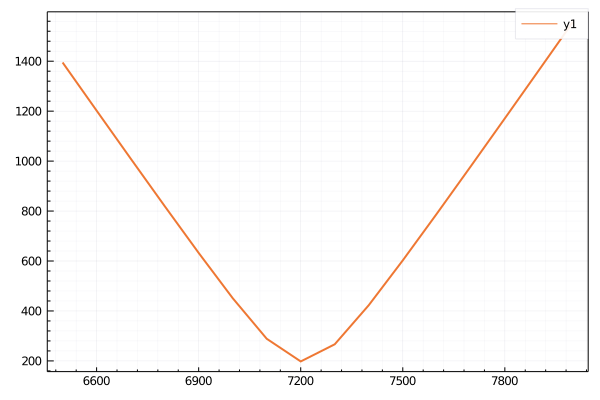

In [19]:
elv=deg2rad.([63.5, 62])
azm=deg2rad.([338, 339])

ar1 = 6.5e3:100:8e3
dist(R1, R2) = norm(R1 .- R2)
plot(ar1, r1->dist(bpoints(elv, azm, 3.3e3, r1)...))

`r1` must be around 7200 km or the velocity would be too high and geometry hard to believe.

Let's define a function to build transmission lines with given elevation and azimuth boundaries.  We also change the current pulse definition to allow a slow, long decaying current that we will use later.
Because now we only see the velocity perpendicular to the line of sight we parameterize the propagation of the pulse with the total time that it takes from one point to the other.  This is an observational fact so it's better than the velocity.

In [76]:
function channel1(;elv=deg2rad.([63.5, 62]),                                                                                              
                 azm=deg2rad.([338, 339]),                                                                                               
                 ρ=3.3e3, r1=7.1e3,                                                                                                      
                 λ=900.0, Ipk=51.5e3,                                                                                                    
                 τ1=1e-6, τ2=5e-6, tp=11e-6,                                                                                             
                 tp1=5e-6, λ1=λ,                                                                                                         
                 I2=0.0, τ3=τ2,                                                                                                          
                 γ=1.0, Δτ=0.0, η=1.0,                                                                                                   
                 bounce=false)                                                                                                           
                                                                                                                                         
    R1, R2 = bpoints(elv, azm, ρ, r1)                                                                                                    
    L = norm(R1 .- R2)                                                                                                                   
                                                                                                                                         
    # Current pulse                                                                                                                      
    α, β = 1 / τ1, 1 / τ2                                                                                                                
    α1, β1 = α, 1 / τ3                                                                                                                   
                                                                                                                                         
    I0 = Ipk * (1 + α / β) * (α / β)^(-α / (α + β))                                                                                      
    I01 = I2 * Ipk * (1 + α1 / β1) * (α1 / β1)^(-α1 / (α1 + β1))                                                                         
                                                                                                                                         
    function fpulse(t)                                                                                                                   
        Ip = I0 * (exp(α * t) / (1 + exp((α + β) * t)))                                                                                  
                                                                                                                                         
        Is = I01 * (exp(α1 * t) / (1 + exp((α1 + β1) * t)))                                                                              
                                                                                                                                         
        Ip + Is                                                                                                                          
    end                                                                                                                                  
                                                                                                                                         
    pulse = CurrentPulse(fpulse,                                                                                                         
                         -max(τ1, τ2) * 5,                                                                                               
                         max(τ1, τ2, τ3) * 20,                                                                                           
                         min(τ1, τ2) / 10)                                                                                               
                                                                                                                                         
    v = L / tp                                                                                                                           
    tl0 = mtle(pulse, R1, R2, v, λ, 1000, mirror=true)                                                                                   
    bounce || return tl0                                                                                                                 
                                                                                                                                         
    v1 = L / tp1                                                                                                                         
    R3 = R2 + (R1 - R2) * η                                                                                                              
                                                                                                                                         
    tl1 = mtle(pulse, R2, R3, v1, λ1, 1000,                                                                                              
        mirror=true,
        w0=-γ * exp(-L / λ),                                                                                                             
        t0=L / v + Δτ)                                                                                                                   
                                                                                                                                         
    tl = (tl0, tl1)                                                                                                                      

    tl                                                                                                                                   
end

channel1 (generic function with 1 method)

In [21]:
t = range(17.5e-6, stop=7e-5, length=1000);

Changing `r1` around 7200 m shows that in some cases the electric field profile resembles much more the observations

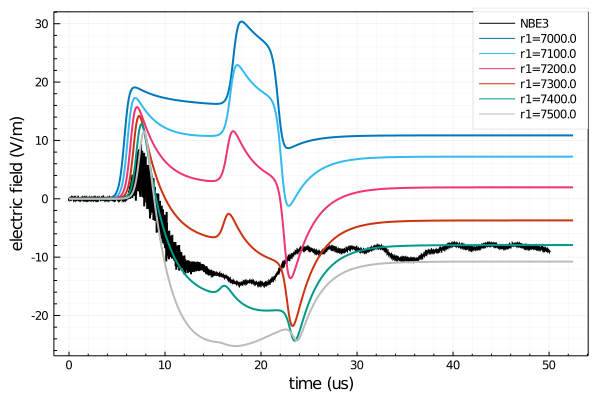

In [95]:
plot(tdata * 1e6, ydata, label="NBE3", color=:black, xlabel="time (us)", ylabel="electric field (V/m)");
shift = 17.5
for r1 in 7e3:100:7.5e3
    tl = channel1(r1=r1, Ipk=65.6e3, λ=900, τ1=0.3e-6, τ2=2.3e-6, tp=10e-6, tp1=6e-6, bounce=true)
    ef = fields(tl, robs, t);

    plot!(t * 1e6 .- shift, total(ef, 3), label="r1=$r1")
end

plot!()

### Final result

Fiddling a bit with the parameters we find that it is possible the fit the observations with reasonable values

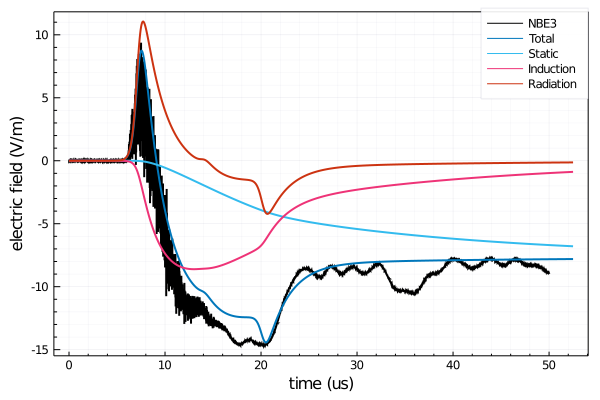

In [115]:
plot(tdata * 1e6, ydata, label="NBE3", color=:black, xlabel="time (us)", ylabel="electric field (V/m)");
shift = 17.5

tl = channel1(r1=7400, Ipk=30.4e3, τ1=0.3e-6, τ2=2.3e-6, τ3=24e-6, I2=0.2, tp=8e-6, tp1=5e-6, λ=600,
    λ1=600, bounce=true);
ef = fields(tl, robs, t);

plot!(t * 1e6 .- shift, total(ef, 3), label="Total")
plot!(t * 1e6 .- shift, static(ef, 3), label="Static")
plot!(t * 1e6 .- shift, induction(ef, 3), label="Induction")
plot!(t * 1e6 .- shift, radiation(ef, 3), label="Radiation")



Let's try to improve the fit 

In [111]:
using LsqFit

# Multiplicative factors to handle parameters of order unity
m = [1e-6, 1e3, 1, 10, 100, 100, 1e-7, 1e-7]

function model(t, p)
    shift, Ipk, I2, r1, λ, λ1, τ2, τ3 = p .* m
    tl = channel1(r1=r1, Ipk=Ipk, τ1=0.3e-6, τ2=τ2, τ3=τ3, I2=I2, tp=11e-6, tp1=6e-6, 
        λ=λ, λ1=λ1, bounce=true);
    ef = fields(tl, robs, t .+ shift);
    return total(ef, 3)
end
p0 = [17.5e-6, 30.4e3, 0.2, 7.6e3, 500, 500, 3e-6, 24e-6] 
@time fit = curve_fit(model, tdata[1:10:end], ydata[1:10:end], p0 ./ m)

# Print the fitted parameters
for (sym, val) in zip([:shift, :Ipk, :I2, :r1, :λ, :λ1, :τ2, :τ3], coef(fit) .* m)) 
    println(sym => val)
end;

385.800811 seconds (7.25 M allocations: 1.871 GiB, 0.09% gc time)


LoadError: syntax: unexpected ")"

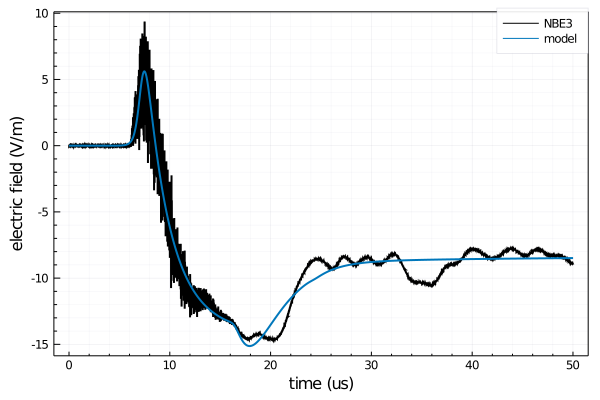

In [112]:
plot(tdata * 1e6, ydata, label="NBE3", color=:black, xlabel="time (us)", ylabel="electric field (V/m)")
plot!(tdata * 1e6, model(tdata, coef(fit)), label="model")
